In [3]:
bemenet = {
    "Fidesz": 35,
    "Tisza": 50,
    "DK": 0,
    "Mi Hazánk": 0,
    "Momentum": 0,
    "MKKP": 0
}

egyeni, listas, ossz, korzetek = valasztasi_modellezes("2024_ep_input_korzetek.csv", bemenet, 4)

print("Egyéni:", egyeni)
print("Listás:", listas)
print("Összes:", ossz)

# Mentés fájlba (pl. CSV-be)
korzetek.to_csv("gyoztes_korzetek_predikalt.csv", index=False)


Egyéni: {'Fidesz': 17, 'Tisza': 89, 'DK': 0, 'Mi Hazánk': 0, 'Momentum': 0, 'MKKP': 0}
Listás: {'Fidesz': 41, 'Tisza': 52}
Összes: {'Fidesz': 58, 'Tisza': 141, 'DK': 0, 'Mi Hazánk': 0, 'Momentum': 0, 'MKKP': 0}


In [2]:
import pandas as pd

def valasztasi_modellezes(csv_path, orszagos_eredmenyek, fix_fidesz_mandatum=3):
    """
    csv_path: pl. "TISZA_FIDESZ_2024_EP.csv"
    orszagos_eredmenyek: dict, pl. {
        "Fidesz": 40.0,
        "Tisza": 35.0,
        "DK": 7.0,
        "Mi Hazánk": 6.0,
        "Momentum": 4.5,
        "MKKP": 5.0
    }
    fix_fidesz_mandatum: int, a Fidesznek automatikusan járó listás mandátumok száma
    """
    # 1. Beolvasás
    df = pd.read_csv(csv_path, sep=';', encoding='utf-8-sig')

    # 2. EP 2024 országos listás eredmény
    ep_fidesz = 44.82
    ep_tisza = 29.6

    # 3. Körzeti arányszám
    df["fidesz_arany"] = df["Fidesz (%)"] / ep_fidesz
    df["tisza_arany"] = df["Tisza (%)"] / ep_tisza

    # 4. Predikció új listás alapján
    df["Fidesz_pred"] = df["fidesz_arany"] * orszagos_eredmenyek["Fidesz"]
    df["Tisza_pred"] = df["tisza_arany"] * orszagos_eredmenyek["Tisza"]

    # 5. Egyéni győztesek
    def gyoztes(row):
        return "Fidesz" if row["Fidesz_pred"] > row["Tisza_pred"] else "Tisza"
    df["Győztes"] = df.apply(gyoztes, axis=1)

    # 6. Egyéni mandátumok
    partok = list(orszagos_eredmenyek.keys())
    egyeni = {p: 0 for p in partok}
    for gyoztes in df["Győztes"]:
        egyeni[gyoztes] += 1

    # 7. Töredék + győzteskompenzáció
    toredek = {p: 0.0 for p in partok}
    gyoztes_komp = {p: 0.0 for p in partok}
    for _, row in df.iterrows():
        f, t = row["Fidesz_pred"], row["Tisza_pred"]
        if f > t:
            toredek["Tisza"] += t
            gyoztes_komp["Fidesz"] += (f - t + 1)
        else:
            toredek["Fidesz"] += f
            gyoztes_komp["Tisza"] += (t - f + 1)

    # 8. Listás szavazatok
    listas = {}
    for p in partok:
        alap = orszagos_eredmenyek[p] * 1000
        frag = toredek.get(p, 0)
        komp = gyoztes_komp.get(p, 0)
        extra = alap if p in ["DK", "Mi Hazánk", "Momentum", "MKKP"] else 0
        listas[p] = alap + frag + komp + extra

    # 9. 5% küszöb
    ervenyes = {p: v for p, v in listas.items() if orszagos_eredmenyek[p] >= 5.0}

    # 10. D’Hondt (93 - fix Fidesz helyek)
    listas_mand = {p: 0 for p in ervenyes}
    for _ in range(93 - fix_fidesz_mandatum):
        legjobb = max(ervenyes, key=lambda p: listas[p] / (listas_mand[p] + 1))
        listas_mand[legjobb] += 1

    # ➕ fix Fidesz mandátum hozzáadása
    if "Fidesz" in listas_mand:
        listas_mand["Fidesz"] += fix_fidesz_mandatum
    else:
        listas_mand["Fidesz"] = fix_fidesz_mandatum

    # 11. Összes mandátum
    osszes = {p: egyeni.get(p, 0) + listas_mand.get(p, 0) for p in partok}

    # 12. Körzeti győztesek listája
    korzet_df = df[["Körzet", "Fidesz_pred", "Tisza_pred", "Győztes"]].copy()

    return egyeni, listas_mand, osszes, korzet_df


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def szimulacio_tisza_tobbseg(csv_path, fix_fidesz_mandatum=3):
    fidesz_alap = 50
    elonyok = np.linspace(-20, 20, 301)  # 0.1-es lépések
    tisza_tobbseg = []
    tisza_mand_list = []

    for tisza_elony in elonyok:
        tisza = fidesz_alap + tisza_elony

        if tisza < 0 or tisza > 100:
            tisza_tobbseg.append(None)
            tisza_mand_list.append(None)
            continue

        eredmenyek = {
            "Fidesz": fidesz_alap,
            "Tisza": tisza,
            "DK": 0,
            "Mi Hazánk": 0,
            "Momentum": 0,
            "MKKP": 0
        }

        _, _, osszes, _ = valasztasi_modellezes(csv_path, eredmenyek, fix_fidesz_mandatum)
        tisza_mand = osszes.get("Tisza", 0)
        tisza_tobbseg.append(tisza_mand - 100)
        tisza_mand_list.append(tisza_mand)

    # Keresés – indexek a kulcspontokhoz
    def legkozelebbi_index(cel):
        return min(
            [(i, abs(m - cel)) for i, m in enumerate(tisza_mand_list) if m is not None],
            key=lambda x: x[1]
        )[0]

    idx_100 = legkozelebbi_index(100)
    idx_133 = legkozelebbi_index(133)
    idx_66 = legkozelebbi_index(66)

    # X és Y értékek ezekhez
    pontok = {
        "100 mandátum": (elonyok[idx_100], tisza_tobbseg[idx_100], 'black'),
        "Tisza 2/3": (elonyok[idx_133], tisza_tobbseg[idx_133], 'blue'),
        "Fidesz 2/3": (elonyok[idx_66], tisza_tobbseg[idx_66], 'red'),
    }

    # Rajz
    plt.figure(figsize=(11, 6))
    plt.plot(elonyok, tisza_tobbseg, color='green', linewidth=2, label='Tisza mandátumtöbbségének trendvonala')

    # Y jelölések
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axhline(33, color='blue', linestyle='--', linewidth=1)
    plt.axhline(-34, color='red', linestyle='--', linewidth=1)

    # X jelölések + pontok és feliratok közvetlenül a görbén
    for label, (x, y, szin) in pontok.items():
        plt.scatter(x, y, color=szin, zorder=5)
        offset = 4 if y >= 0 else -6
        plt.text(x, y + offset, f"{label}\n({x:+.1f}%)", ha='center', fontsize=8, color=szin)

    # Árnyékolás
    plt.axhspan(0, max(tisza_tobbseg or [0]), color='lightgreen', alpha=0.15)
    plt.axhspan(min(tisza_tobbseg or [0]), 0, color='lightcoral', alpha=0.15)

    # Tengelyek
    plt.xlabel("Tisza listás előnye (%) a Fideszhez képest")
    plt.ylabel("Tisza mandátumtöbbsége (± a többséghez képest)")
    plt.title("Tisza mandátumtöbbsége a Fideszhez viszonyított listaeredmény függvényében")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("tisza_tobbseg.png", dpi=300)
    plt.show()


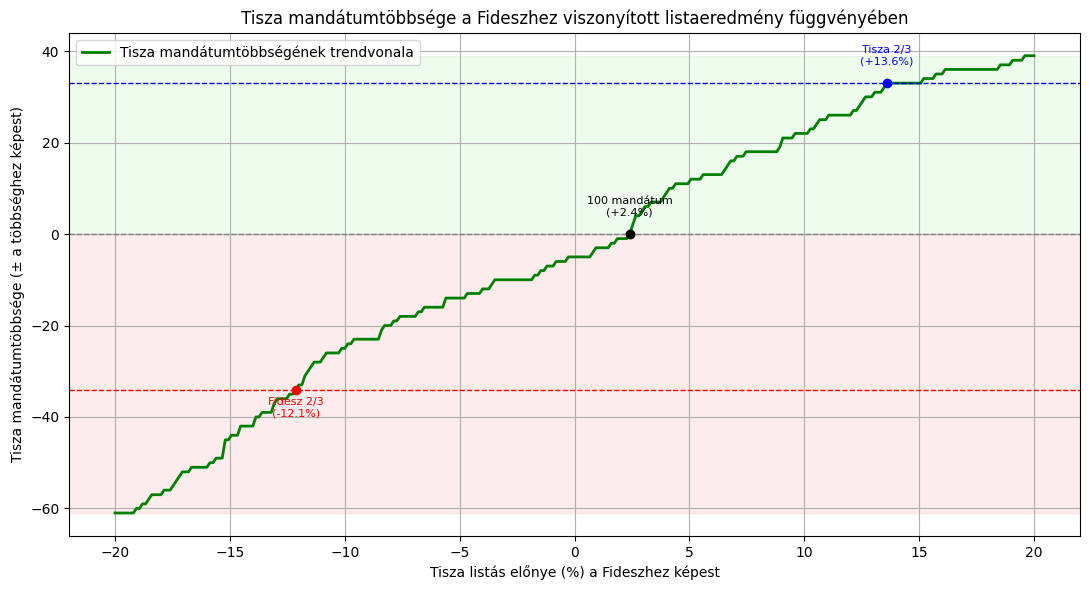

In [5]:
szimulacio_tisza_tobbseg("2024_ep_input_korzetek.csv")

In [ ]:
#semmi
import pandas as pd
from bs4 import BeautifulSoup
import unidecode

def korzet_to_svg_id(korzetnev):
    """Körzet nevét SVG azonosítóvá alakítja."""
    s = unidecode.unidecode(korzetnev.lower()).replace("–", "-").replace(" ", "-")
    helyettesites = {
        "borsod-abauj-zemplen": "borsod", "szabolcs-szatmar-bereg": "szabolcs",
        "jasz-nagykun-szolnok": "jasz", "gyor-moson-sopron": "gyor",
        "komarom-esztergom": "komarom", "bacs-kiskun": "bacs",
        "csongrad-csanad": "csongrad", "hajdu-bihar": "hajdu"
    }
    for regi, uj in helyettesites.items():
        s = s.replace(regi, uj)
    return s

def valasztasi_modellezes(csv_path, orszagos_eredmenyek, fix_fidesz_mandatum=3):
    """Választási eredmények modellezése körzetenként."""
    df = pd.read_csv(csv_path, sep=';', encoding='utf-8-sig')
    ep_fidesz, ep_tisza = 44.82, 29.6
    df["fidesz_arany"] = df["Fidesz (%)"] / ep_fidesz
    df["tisza_arany"] = df["Tisza (%)"] / ep_tisza
    df["Fidesz_pred"] = df["fidesz_arany"] * orszagos_eredmenyek["Fidesz"]
    df["Tisza_pred"] = df["tisza_arany"] * orszagos_eredmenyek["Tisza"]
    df["Különbség"] = df["Tisza_pred"] - df["Fidesz_pred"]  # Módosítva: Tisza előnye pozitív
    df["Győztes"] = df.apply(lambda r: "Tisza" if r["Különbség"] > 0 else "Fidesz", axis=1)  # Módosítva
    return df[["Körzet", "Győztes", "Különbség"]].copy()

def szin_kulonbseg_alapjan(gyoztes, kulonbseg):
    """Szín kiválasztása a győztes és a különbség alapján."""
    if gyoztes == "Tisza":
        if kulonbseg >= 15: return "#0D1B42"  # Sötétkék: Tisza nagy előnye
        elif kulonbseg >= 12: return "#2b395f"
        elif kulonbseg >= 9: return "#48577c"
        elif kulonbseg >= 6: return "#667498"
        elif kulonbseg >= 3: return "#8392b5"
        elif kulonbseg > 0: return "#a1b0d2"  # Világoskék: Kis Tisza előny
    elif gyoztes == "Fidesz":
        if kulonbseg <= -15: return "#bb4d06"  # Sötét narancssárga: Fidesz nagy előnye
        elif kulonbseg <= -12: return "#c36224"
        elif kulonbseg <= -9: return "#cb7842"
        elif kulonbseg <= -6: return "#d48d5f"
        elif kulonbseg <= -3: return "#dca37d"
        elif kulonbseg < 0: return "#e4b89b"  # Fehér: Kis Fidesz előny
    return "#CCCCCC"

def rajzolj_legendat_vizszintes(soup, text_size=10, label_size=10):
    """Vízszintes legenda rajzolása az SVG-be, felcserélt tartományokkal."""
    if label_size is None:
        label_size = text_size

    group = soup.new_tag("g", id="legend_horiz")
    x0, y0, blokkszel, blokk_mag = 30, 50, 70, 15
    # Színek megfordítva: baloldalon narancssárga (Fidesz előnye), jobboldalon kék (Tisza előnye)
    szinlepesek = [
        "#cc5200", "#FF6A00", "#FF8A40", "#FFB278", "#FFE0C0", "#FFFFFF",
        "#DDE5F0", "#A7B8D8", "#5C7DC2", "#3350AA", "#1F3171", "#0D1B42"
    ]

    felirat = soup.new_tag("text", x=str(x0), y=str(y0 - 15), fill="black",
                           **{"font-size": str(text_size), "font-family": "sans-serif"})
    felirat.string = "*A Tisza Párt előnye/hátránya körzetenként"
    group.append(felirat)

    # Színblokkok kirajzolása
    for i, color in enumerate(szinlepesek):
        x = x0 + i * blokkszel
        rect = soup.new_tag("rect", x=str(x), y=str(y0),
                            width=str(blokkszel), height=str(blokk_mag), fill=color)
        group.append(rect)

    # Címkék: -15% (Fidesz előnye) baloldalon, +15% (Tisza előnye) jobboldalon
    label_values = [
        ("-15%", 0.5), ("-12%", 1.5), ("-9%", 2.5), ("-6%", 3.5),
        ("-3%", 4.5), ("0%", 5.5), ("+3%", 6.5), ("+6%", 7.5),
        ("+9%", 8.5), ("+12%", 9.5), ("+15%", 10.5)
    ]

    for label, i in label_values:
        x = x0 + i * blokkszel + blokkszel / 2
        text = soup.new_tag("text", x=str(x), y=str(y0 + blokk_mag + 20),
                            fill="black", **{"font-size": str(label_size), "font-family": "sans-serif", "text-anchor": "middle"})
        text.string = label
        group.append(text)

    soup.svg.append(group)

def szinezd_svg_korzetek(svg_path, korzet_df, output_path):
    """SVG térkép színezése a körzetek adatai alapján."""
    with open(svg_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f.read(), "xml")

    svg_tag = soup.find("svg")

    if svg_tag.has_attr("viewBox"):
        values = list(map(float, svg_tag["viewBox"].split()))
    else:
        width = float(svg_tag.get("width", 0))
        height = float(svg_tag.get("height", 0))
        values = [0.0, 0.0, width, height]
        svg_tag["viewBox"] = f"{values[0]} {values[1]} {values[2]} {values[3]}"

    values[2] *= 2
    values[3] *= 2
    svg_tag["viewBox"] = " ".join(map(str, values))
    svg_tag["width"] = str(values[2])
    svg_tag["height"] = str(values[3])

    for path in soup.find_all("path"):
        if "transform" in path.attrs:
            path["transform"] = f"scale(2) {path['transform']}"
        else:
            path["transform"] = "scale(2)"

    for text in soup.find_all("text"):
        if "font-size" in text.attrs:
            original_size = float(text["font-size"])
            text["font-size"] = str(original_size * 2)
        else:
            text["font-size"] = "20"

        if "x" in text.attrs:
            text["x"] = str(float(text["x"]) * 2)
        if "y" in text.attrs:
            text["y"] = str(float(text["y"]) * 2)

    for _, row in korzet_df.iterrows():
        korzet_id = korzet_to_svg_id(row["Körzet"])
        path = soup.find("path", {"id": korzet_id})
        if path:
            szin = szin_kulonbseg_alapjan(row["Győztes"], row["Különbség"])
            path["style"] = f"fill: {szin}; stroke: #000; stroke-width: 0.3;"

    rajzolj_legendat_vizszintes(soup, text_size=26, label_size=18)

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(str(soup))

# === FUTTATÁS ===
csv_path = "2024_ep_input_korzetek.csv"
svg_path = "2026_korzetek_alap.svg"
output_svg_path = "2026_korzetek_szinezve.svg"

orszagos_eredmenyek = {
    "Fidesz": 50.0,
    "Tisza": 50.0,
    "DK": 7.0,
    "Mi Hazánk": 6.0,
    "Momentum": 4.5,
    "MKKP": 5.0
}

korzet_df = valasztasi_modellezes(csv_path, orszagos_eredmenyek)
szinezd_svg_korzetek(svg_path, korzet_df, output_svg_path)

In [ ]:
#Sima
import pandas as pd
from bs4 import BeautifulSoup
import unidecode
import os
from datetime import date

def korzet_to_svg_id(korzetnev):
    """Körzet nevét SVG azonosítóvá alakítja."""
    s = unidecode.unidecode(korzetnev.lower()).replace("–", "-").replace(" ", "-")
    helyettesites = {
        "borsod-abauj-zemplen": "borsod", "szabolcs-szatmar-bereg": "szabolcs",
        "jasz-nagykun-szolnok": "jasz", "gyor-moson-sopron": "gyor",
        "komarom-esztergom": "komarom", "bacs-kiskun": "bacs",
        "csongrad-csanad": "csongrad", "hajdu-bihar": "hajdu"
    }
    for regi, uj in helyettesites.items():
        s = s.replace(regi, uj)
    return s

def valasztasi_modellezes(csv_path, orszagos_eredmenyek):
    """Választási eredmények modellezése körzetenként."""
    df = pd.read_csv(csv_path, sep=';', encoding='utf-8-sig')
    ep_fidesz, ep_tisza = 44.82, 29.6
    df["fidesz_arany"] = df["Fidesz (%)"] / ep_fidesz
    df["tisza_arany"] = df["Tisza (%)"] / ep_tisza
    df["Fidesz_pred"] = df["fidesz_arany"] * orszagos_eredmenyek["Fidesz"]
    df["Tisza_pred"] = df["tisza_arany"] * orszagos_eredmenyek["Tisza"]
    df["Különbség"] = df["Tisza_pred"] - df["Fidesz_pred"]
    df["Győztes"] = df.apply(lambda r: "Tisza" if r["Különbség"] > 0 else "Fidesz", axis=1)
    return df[["Körzet", "Győztes", "Különbség"]].copy()

def szin_kulonbseg_alapjan(gyoztes, kulonbseg):
    """Szín kiválasztása a győztes és a különbség alapján."""
    if gyoztes == "Tisza":
        if kulonbseg >= 15: return "#1a2a6c"
        elif kulonbseg >= 12: return "#324577"
        elif kulonbseg >= 9: return "#4e6494"
        elif kulonbseg >= 6: return "#6b83b1"
        elif kulonbseg >= 3: return "#8fa3cc"
        elif kulonbseg > 0: return "#b3c4e7"
    elif gyoztes == "Fidesz":
        if kulonbseg <= -15: return "#bb4d06"
        elif kulonbseg <= -12: return "#c75f1c"
        elif kulonbseg <= -9: return "#d27332"
        elif kulonbseg <= -6: return "#dd8751"
        elif kulonbseg <= -3: return "#e89c6f"
        elif kulonbseg < 0: return "#f3b18e"
    return "#CCCCCC"

def rajzolj_legendat_vizszintes(soup, text_size=10, label_size=10):
    """Vízszintes legenda rajzolása az SVG-be."""
    if label_size is None:
        label_size = text_size

    group = soup.new_tag("g", id="legend_horiz")
    x0, y0, blokkszel, blokk_mag = 30, 50, 70, 15
    szinlepesek = [
        "#bb4d06", "#c75f1c", "#d27332", "#dd8751", "#e89c6f", "#f3b18e",
        "#b3c4e7", "#8fa3cc", "#6b83b1", "#4e6494", "#324577", "#0D1a2a6c1B42"
    ]

    felirat = soup.new_tag("text", x=str(x0), y=str(y0 - 15), fill="black",
                           **{"font-size": str(text_size), "font-family": "sans-serif"})
    felirat.string = "*A Tisza Párt előnye/hátránya körzetenként"
    group.append(felirat)

    for i, color in enumerate(szinlepesek):
        x = x0 + i * blokkszel
        rect = soup.new_tag("rect", x=str(x), y=str(y0),
                            width=str(blokkszel), height=str(blokk_mag), fill=color)
        group.append(rect)

    label_values = [
        ("-15%", 0.5), ("-12%", 1.5), ("-9%", 2.5), ("-6%", 3.5),
        ("-3%", 4.5), ("0%", 5.5), ("+3%", 6.5), ("+6%", 7.5),
        ("+9%", 8.5), ("+12%", 9.5), ("+15%", 10.5)
    ]

    for label, i in label_values:
        x = x0 + i * blokkszel + blokkszel / 2
        text = soup.new_tag("text", x=str(x), y=str(y0 + blokk_mag + 20),
                            fill="black", **{"font-size": str(label_size), "font-family": "sans-serif", "text-anchor": "middle"})
        text.string = label
        group.append(text)

    soup.svg.append(group)

def sima_terkep_svg(svg_path, korzet_df):
    """SVG térkép színezése a körzetek adatai alapján, mentés dátum szerint."""
    with open(svg_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f.read(), "xml")

    svg_tag = soup.find("svg")

    if svg_tag.has_attr("viewBox"):
        values = list(map(float, svg_tag["viewBox"].split()))
    else:
        width = float(svg_tag.get("width", 0))
        height = float(svg_tag.get("height", 0))
        values = [0.0, 0.0, width, height]
        svg_tag["viewBox"] = f"{values[0]} {values[1]} {values[2]} {values[3]}"

    values[2] *= 2
    values[3] *= 2
    svg_tag["viewBox"] = " ".join(map(str, values))
    svg_tag["width"] = str(values[2])
    svg_tag["height"] = str(values[3])

    # Fehér háttér hozzáadása
    background = soup.new_tag("rect", x="0", y="0", width=str(values[2]), height=str(values[3]), fill="#FFFFFF")
    svg_tag.insert(0, background)

    for path in soup.find_all("path"):
        if "transform" in path.attrs:
            path["transform"] = f"scale(2) {path['transform']}"
        else:
            path["transform"] = "scale(2)"

    for text in soup.find_all("text"):
        if "font-size" in text.attrs:
            original_size = float(text["font-size"])
            text["font-size"] = str(original_size * 2)
        else:
            text["font-size"] = "20"

        if "x" in text.attrs:
            text["x"] = str(float(text["x"]) * 2)
        if "y" in text.attrs:
            text["y"] = str(float(text["y"]) * 2)

    for _, row in korzet_df.iterrows():
        korzet_id = korzet_to_svg_id(row["Körzet"])
        path = soup.find("path", {"id": korzet_id})
        if path:
            szin = szin_kulonbseg_alapjan(row["Győztes"], row["Különbség"])
            path["style"] = f"fill: {szin}; stroke: #000; stroke-width: 0.3;"

    rajzolj_legendat_vizszintes(soup, text_size=26, label_size=18)

    today_str = date.today().isoformat()
    os.makedirs("sima_terkep", exist_ok=True)
    output_path = os.path.join("sima_terkep", f"{today_str}.svg")

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(str(soup))

# === FUTTATÁS ===
csv_path = "2024_ep_input_korzetek.csv"
svg_path = "2026_korzetek_alap.svg"
orszagos_eredmenyek = {
    "Fidesz": 50.0,
    "Tisza": 50.0
}

korzet_df = valasztasi_modellezes(csv_path, orszagos_eredmenyek)
sima_terkep_svg(svg_path, korzet_df)


In [57]:
#Gradient
import pandas as pd
from bs4 import BeautifulSoup
import unidecode
import numpy as np
from datetime import date
import os


def korzet_to_svg_id(korzetnev):
    s = unidecode.unidecode(korzetnev.lower()).replace("–", "-").replace(" ", "-")
    helyettesites = {
        "borsod-abauj-zemplen": "borsod", "szabolcs-szatmar-bereg": "szabolcs",
        "jasz-nagykun-szolnok": "jasz", "gyor-moson-sopron": "gyor",
        "komarom-esztergom": "komarom", "bacs-kiskun": "bacs",
        "csongrad-csanad": "csongrad", "hajdu-bihar": "hajdu"
    }
    for regi, uj in helyettesites.items():
        s = s.replace(regi, uj)
    return s


def valasztasi_modellezes(csv_path, orszagos_eredmenyek):
    df = pd.read_csv(csv_path, sep=';', encoding='utf-8-sig')
    ep_fidesz, ep_tisza = 44.82, 29.6
    df["fidesz_arany"] = df["Fidesz (%)"] / ep_fidesz
    df["tisza_arany"] = df["Tisza (%)"] / ep_tisza
    df["Fidesz_pred"] = df["fidesz_arany"] * orszagos_eredmenyek["Fidesz"]
    df["Tisza_pred"] = df["tisza_arany"] * orszagos_eredmenyek["Tisza"]
    df["Különbség"] = df["Tisza_pred"] - df["Fidesz_pred"]
    df["Győztes"] = df.apply(lambda r: "Tisza" if r["Különbség"] > 0 else "Fidesz" if r["Különbség"] < 0 else None, axis=1)
    df["Különbség"] = df["Különbség"].round(2)
    return df[["Körzet", "Győztes", "Különbség"]].copy()


TISZA_LIGHT = (0xA1, 0xB0, 0xD2)
TISZA_DARK = (0x24, 0x3B, 0x72)
FIDESZ_LIGHT = (0xE4, 0xB8, 0x9B)
FIDESZ_DARK = (0xBB, 0x4D, 0x06)
GREY = "#FFFFFF" 

def safe_max(series):
    val = series.max()
    return val if not np.isnan(val) else 0.0

def safe_min(series):
    val = series.min()
    return val if not np.isnan(val) else 0.0

def interpolate_color(c1, c2, t):
    r = int(c1[0] + (c2[0] - c1[0]) * t)
    g = int(c1[1] + (c2[1] - c1[1]) * t)
    b = int(c1[2] + (c2[2] - c1[2]) * t)
    return f"#{r:02x}{g:02x}{b:02x}"


def szin_kulonbseg_alapjan(row, max_val, absolute_max):
    gyoztes = row["Győztes"]
    kulonbseg = abs(row["Különbség"])
    scaled_t = min(kulonbseg / max_val, 1.0) if max_val else 0
    if gyoztes == "Tisza":
        return interpolate_color(TISZA_LIGHT, TISZA_DARK, scaled_t)
    elif gyoztes == "Fidesz":
        return interpolate_color(FIDESZ_LIGHT, FIDESZ_DARK, scaled_t)
    return GREY


def rajzolj_legendat(soup, tisza_min, tisza_max, fidesz_min, fidesz_max):
    defs = soup.new_tag("defs")

    def create_gradient(id_, c_light, c_dark):
        grad = soup.new_tag("linearGradient", id=id_, x1="0%", y1="0%", x2="100%", y2="0%")
        grad.append(soup.new_tag("stop", offset="0%", **{"stop-color": interpolate_color(c_light, c_dark, 0)}))
        grad.append(soup.new_tag("stop", offset="100%", **{"stop-color": interpolate_color(c_light, c_dark, 1)}))
        return grad

    show_tisza = tisza_max > 0
    show_fidesz = fidesz_max > 0

    if show_tisza:
        defs.append(create_gradient("grad_tisza", TISZA_LIGHT, TISZA_DARK))
    if show_fidesz:
        defs.append(create_gradient("grad_fidesz", FIDESZ_LIGHT, FIDESZ_DARK))

    soup.svg.insert(0, defs)

    viewbox = list(map(float, soup.svg["viewBox"].split()))
    bg_rect = soup.new_tag("rect", x=str(viewbox[0]), y=str(viewbox[1]),
                           width=str(viewbox[2]), height=str(viewbox[3]),
                           fill="#FFFFFF")
    soup.svg.insert(1, bg_rect)

    group = soup.new_tag("g", id="legend", transform="translate(50, 30)")
    box_width = 260
    box_height = 30

    legends = []
    if show_tisza:
        legends.append(("grad_tisza", "Tisza", interpolate_color(TISZA_LIGHT, TISZA_DARK, 0.8), tisza_min, tisza_max))
    if show_fidesz:
        legends.append(("grad_fidesz", "Fidesz", interpolate_color(FIDESZ_LIGHT, FIDESZ_DARK, 0.8), fidesz_min, fidesz_max))

    for i, (grad_id, label, color, min_val, max_val) in enumerate(legends):
        y = i * 80
        rect = soup.new_tag("rect", x="0", y=str(y), width=str(box_width), height=str(box_height), fill=f"url(#{grad_id})")
        group.append(rect)

        for pos, val in zip([0, box_width / 2, box_width], [min_val, (min_val + max_val)/2, max_val]):
            label_text = soup.new_tag("text", x=str(pos), y=str(y + box_height + 18), fill=color,
                                      **{"font-size": "16", "text-anchor": "middle", "font-weight": "bold"})
            label_text.string = f"{val:.2f}%"
            group.append(label_text)

        text = soup.new_tag("text", x=str(box_width + 12), y=str(y + box_height - 3), fill=color,
                            **{"font-size": "18", "font-weight": "bold"})
        text.string = label
        group.append(text)

    soup.svg.append(group)


def gradient_terkep_svg(svg_path, korzet_df):
    today = date.today().isoformat()
    os.makedirs("gradient_terkep", exist_ok=True)
    output_path = f"gradient_terkep/{today}.svg"

    with open(svg_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f.read(), "xml")

    svg_tag = soup.find("svg")
    viewbox = svg_tag.get("viewBox")
    if viewbox:
        x, y, w, h = map(float, viewbox.split())
        svg_tag["viewBox"] = f"{x} {y} {w * 2} {h * 2}"
        svg_tag["width"] = str(w * 2)
        svg_tag["height"] = str(h * 2)

    for path in soup.find_all("path"):
        path["transform"] = f"scale(2) {path.get('transform', '')}".strip()

    for text in soup.find_all("text"):
        text["font-size"] = str(float(text.get("font-size", 10)) * 2)
        if "x" in text.attrs:
            text["x"] = str(float(text["x"]) * 2)
        if "y" in text.attrs:
            text["y"] = str(float(text["y"]) * 2)

    tisza_vals = korzet_df[korzet_df["Győztes"] == "Tisza"]["Különbség"].abs()
    fidesz_vals = korzet_df[korzet_df["Győztes"] == "Fidesz"]["Különbség"].abs()

    max_tisza = safe_max(tisza_vals)
    max_fidesz = safe_max(fidesz_vals)
    min_tisza = safe_min(tisza_vals)
    min_fidesz = safe_min(fidesz_vals)
    absolute_max = max(max_tisza, max_fidesz)

    for _, row in korzet_df.iterrows():
        korzet_id = korzet_to_svg_id(row["Körzet"])
        path = soup.find("path", {"id": korzet_id})
        if path:
            szin = szin_kulonbseg_alapjan(row, absolute_max, absolute_max)
            path["style"] = f"fill: {szin}; stroke: #000; stroke-width: 0.3;"

    rajzolj_legendat(soup, min_tisza, max_tisza, min_fidesz, max_fidesz)

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(str(soup))


# === FUTTATÁS ===
csv_path = "2024_ep_input_korzetek.csv"
svg_path = "2026_korzetek_alap.svg"

orszagos_eredmenyek = {
    "Fidesz": 50.0,
    "Tisza": 50.0,
}

korzet_df = valasztasi_modellezes(csv_path, orszagos_eredmenyek)
gradient_terkep_svg(svg_path, korzet_df)